In [197]:
from pyabc import History
import pandas as pd
from ionchannelABC.utils import weighted_cv
from pyabc.weighted_statistics import weighted_mean
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

### Load history files

In [239]:
h_nyg_reported = History('sqlite:///'+
                         '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/ina/reported/nygren_ina_reported.db')

In [236]:
h_nyg = History('sqlite:///'+
                '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/nygren/ina/full/nygren_ina_full2.db')

In [237]:
h_cou_m = History('sqlite:///'+
                  '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/ina/reported/courtemanche_mgate_reported.db')
h_cou_h = History('sqlite:///'+
                  '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/ina/reported/courtemanche_hgate_reported.db')
h_cou_j = History('sqlite:///'+
                  '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/courtemanche/ina/reported/courtemanche_jgate_reported.db')

In [238]:
h_sta = History('sqlite:///'+
                '/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/standardised/ina/standardised_ina_full.db')

## Load databases and weightings

In [274]:
def get_converge_index(h, converge=0.01):
    eps = h.get_all_populations()['epsilon'][1:].tolist()
    resid = []
    for i in range(len(eps)-1):
        resid.append(abs(eps[i]-eps[i+1])/eps[i])
    plt.semilogy(resid)
    plt.axhline(y=converge, linestyle='--', color='k')
    
    converge_index = np.argwhere(np.asarray(resid)<=converge)
    if len(converge_index)==0:
        converge_index = len(eps)-1
    else:
        converge_index = converge_index[0][0]+1
    return converge_index

### NYG

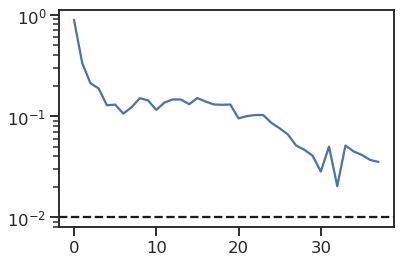

In [326]:
converge_index = get_converge_index(h_nyg_reported)

In [327]:
df_nyg_reported, w_nyg_reported = h_nyg_reported.get_distribution(m=0, t=converge_index)

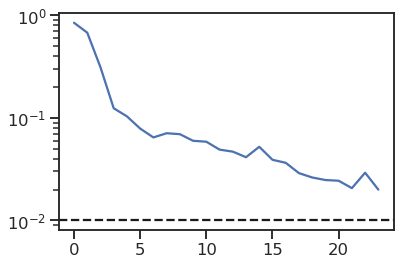

In [328]:
converge_index = get_converge_index(h_nyg)

In [329]:
df_nyg, w_nyg = h_nyg.get_distribution(m=0, t=converge_index)

### COU

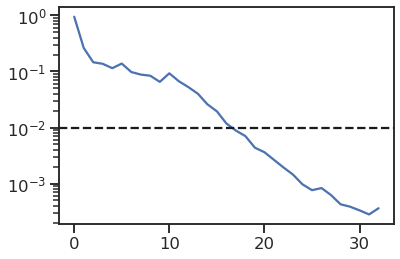

In [330]:
converge_index = get_converge_index(h_cou_m)

In [331]:
df_cou_m, w_cou_m = h_cou_m.get_distribution(m=0, t=converge_index)

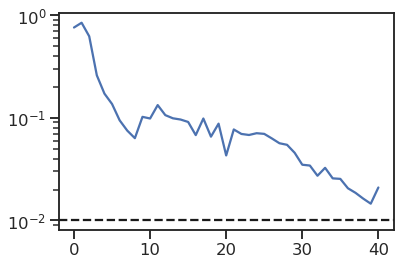

In [332]:
converge_index = get_converge_index(h_cou_h)

In [333]:
df_cou_h, w_cou_h = h_cou_h.get_distribution(m=0, t=converge_index)

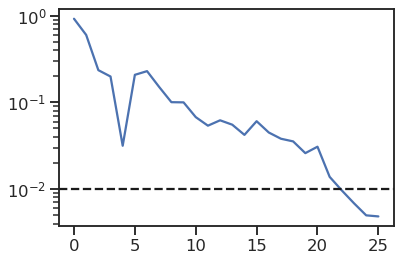

In [334]:
converge_index = get_converge_index(h_cou_j)

In [335]:
df_cou_j, w_cou_j = h_cou_j.get_distribution(m=0, t=converge_index)

### STA

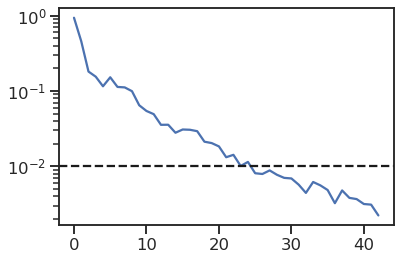

In [336]:
converge_index = get_converge_index(h_sta)

In [337]:
df_sta, w_sta = h_sta.get_distribution(m=0, t=converge_index)

## Compare number of parameters

In [290]:
data = [['NYG',6,9],['COU',6,25],['STA',4,5]]

In [291]:
df = pd.DataFrame(data, columns = ['model', 'act', 'inact'])

In [292]:
df.inact = df.act+df.inact

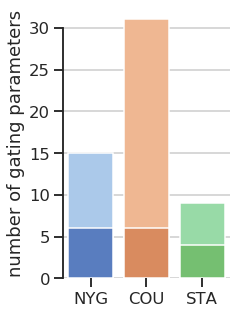

In [293]:
sns.set(style="ticks")
sns.set_context('talk')
sns.set_color_codes("pastel")

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plt.subplots(figsize=(3,5))

sns.barplot(x="model", y="inact", hue="model", data=df,
            palette="pastel", dodge=False)
            #label="inact", color="b")

sns.set_color_codes("muted")
sns.barplot(x="model", y="act", hue="model", data=df,
            palette="muted", dodge=False)
            #label="act", color="r")

handles, labels = ax.get_legend_handles_labels()
order = []
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
          ncol=2, loc="lower right", frameon=False)
ax.set(ylabel="number of gating parameters")
ax.yaxis.grid(True)
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)

In [155]:
#f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/param_num_compare.pdf')

### Compare original and full datasets

In [338]:
cv_nyg_reported = weighted_cv(df_nyg_reported, w_nyg_reported, sample_size=2000)
model = ['NYG',]*len(cv_nyg_reported)
data = ['ORIGINAL',]*len(cv_nyg_reported)
frame = {'model': model, 'data': data, 'CV': cv_nyg_reported}
nyg_reported = pd.DataFrame(frame)

In [339]:
cv_nyg = weighted_cv(df_nyg, w_nyg, sample_size=2000)
model = ['NYG',]*len(cv_nyg)
data = ['COMPLETE',]*len(cv_nyg)
frame = {'model': model, 'data': data, 'CV': cv_nyg}
nyg = pd.DataFrame(frame)

In [340]:
old_vs_new = pd.concat([nyg_reported, nyg])

(array([0, 1]), <a list of 2 Text xticklabel objects>)

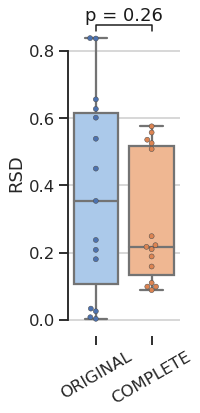

In [341]:
sns.set(style="ticks")
sns.set_context('talk')
sns.set_color_codes('pastel')

# Initialize the figure
f, ax = plt.subplots(figsize=(2, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='data', y='CV', data=old_vs_new,
              palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x='data', y='CV', data=old_vs_new,
              dodge=True, linewidth=0.5
            )

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)

# statistical annotation
x1, x2 = 0, 1   # columns
y, h, col = old_vs_new['CV'].max() + 0.02, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p = 0.26", ha='center', va='bottom', color=col)

plt.xticks(rotation=30)

In [22]:
#f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/nyg_add_data.pdf')

In [342]:
diff = nyg.CV-nyg_reported.CV
ss.wilcoxon(diff)

WilcoxonResult(statistic=40.0, pvalue=0.25598851167013814)

In [343]:
nyg_pars_reported = df_nyg_reported.sample(n=100, weights=w_nyg_reported, replace=True)
nyg_pars_reported = nyg_pars_reported.set_index([pd.Index(range(100))])
nyg_pars_reported = nyg_pars_reported.to_dict(orient='records')

In [344]:
nyg_pars = df_nyg.sample(n=100, weights=w_nyg, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(100))])
nyg_pars = nyg_pars.to_dict(orient='records')

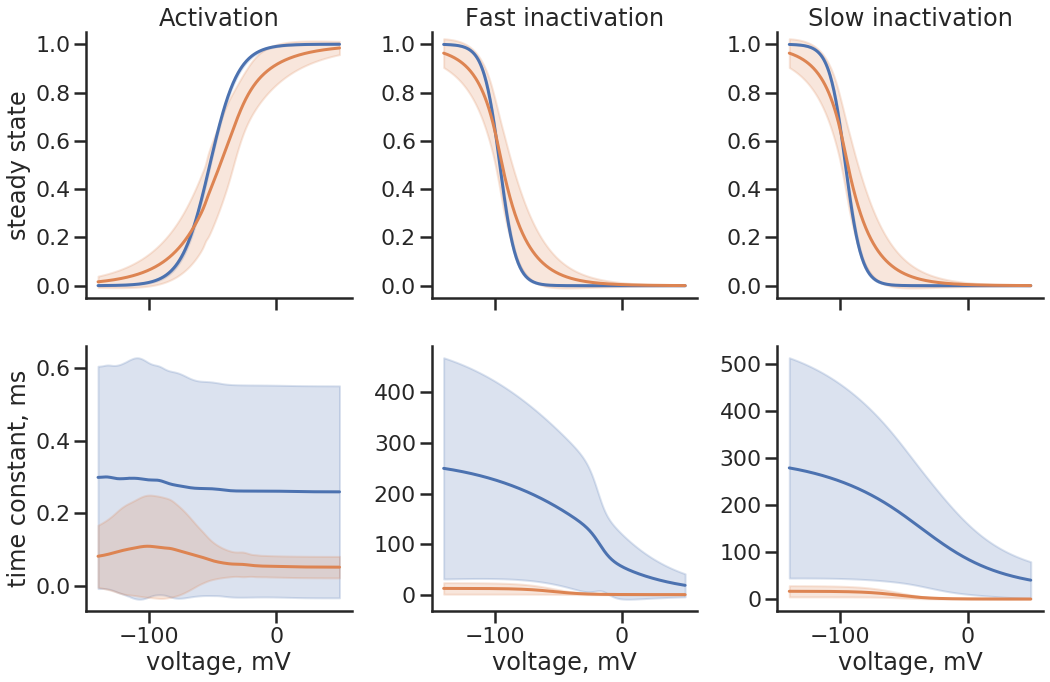

In [345]:
from ionchannelABC.visualization import plot_variables
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

v = np.arange(-140, 50, 0.5)

nyg_vars = {'mi': 'ina.m_ss',
            'hi': 'ina.h_ss',
            'ji': 'ina.h_ss',
            'mt': 'ina.tau_m',
            'ht': 'ina.tau_h1',
            'jt': 'ina.tau_h2'}

f, ax = plot_variables(v, [nyg_vars, nyg_vars], 
                       ['models/nygren_ina.mmt', 'models/nygren_ina_full.mmt'], 
                       [nyg_pars_reported, nyg_pars],
                       figshape=(3,2))

ax[0][0].set_ylabel('steady state')
for a in ax[0][1:]:
    a.set_ylabel('')
ax[0][0].set_title('Activation')
ax[0][1].set_title('Fast inactivation')
ax[0][2].set_title('Slow inactivation')

for a in ax[0][:]:
    a.set_ylim((-0.05, 1.05))

ax[1][0].set_ylabel('time constant, ms')
for a in ax[1][1:]:
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage, mV')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [60]:
#f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/nyg_add_data_gates.pdf')

In [346]:
cv_cou_m = weighted_cv(df_cou_m, w_m, sample_size=500)
cv_cou_h = weighted_cv(df_cou_h, w_h, sample_size=1000)
cv_cou_j = weighted_cv(df_cou_j, w_j, sample_size=2000)

cv_cou = pd.concat([cv_cou_m, cv_cou_h, cv_cou_j])
model = ['COU',]*len(cv_cou)
data = ['ORIGINAL',]*len(cv_cou)
frame = {'model': model, 'data': data, 'CV': cv_cou}
cou = pd.DataFrame(frame)

In [351]:
df = pd.concat([nyg_reported, cou])

Text(0.5, 3.178869032700008, 'p = 0.29')

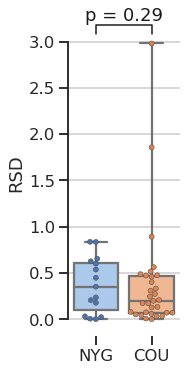

In [352]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(2, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='model', y='CV', data=df,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x='model', y='CV', data=df,
              linewidth=0.5)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)

# statistical annotation
x1, x2 = 0, 1   # columns
y, h, col = df['CV'].max() + 0.1, 0.1, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "p = 0.29", ha='center', va='bottom', color=col)

In [349]:
#f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/cv_original.pdf')

In [353]:
ss.mannwhitneyu(df[df.model=='NYG'].CV, df[df.model=='COU'].CV)

MannwhitneyuResult(statistic=202.0, pvalue=0.24103738370809785)

## Standardised model

In [354]:
eps_sta = h_sta.get_weighted_distances()

In [355]:
weighted_mean(eps_sta.distance, eps_sta.w)

0.7336410852909407

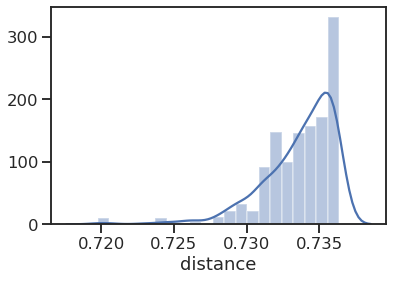

In [356]:
sns.distplot(eps_sta.distance, hist_kws={'weights': eps_sta.w})

In [357]:
cv_sta = weighted_cv(df_sta, w_sta, sample_size=500)

In [358]:
model = ['STA',]*len(cv_sta)
frame = {'model': model, 'CV': cv_sta}
sta = pd.DataFrame(frame)

In [359]:
df = pd.concat([nyg, cou, sta])

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


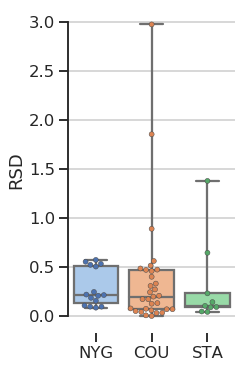

In [360]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(3, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='model', y='CV', data=df,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x='model', y='CV', data=df,
              linewidth=0.5)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="RSD")
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)

In [361]:
#f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/compare_cv_full.pdf')

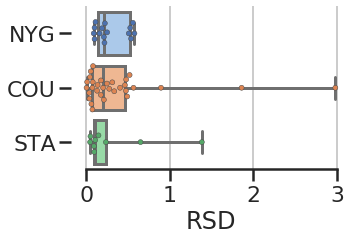

In [362]:
sns.set(style="ticks")
sns.set_context('poster')

# Initialize the figure
f, ax = plt.subplots(figsize=(5, 3))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='CV', y='model', data=df,
            palette="pastel", whis="range")

# Add in points to show each observation
sns.swarmplot(x='CV', y='model', data=df,
              linewidth=0.5)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="RSD")
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [363]:
ss.mannwhitneyu(df[df.model=='NYG'].CV, df[df.model=='STA'].CV)

MannwhitneyuResult(statistic=48.0, pvalue=0.12861949259051314)

In [364]:
ss.mannwhitneyu(df[df.model=='COU'].CV, df[df.model=='STA'].CV)

MannwhitneyuResult(statistic=130.0, pvalue=0.385334332490282)

In [365]:
ss.mannwhitneyu(df[df.model=='NYG'].CV, df[df.model=='COU'].CV)

MannwhitneyuResult(statistic=189.0, pvalue=0.1568257635372089)

In [33]:
#f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/compare_cv_full.pdf')

### Plot epsilon comparison

In [178]:
eps_cou_m = h_cou_m.get_weighted_distances()
eps_cou_h = h_cou_h.get_weighted_distances()
eps_cou_j = h_cou_j.get_weighted_distances()

In [179]:
# Create virtual COU epsilon dataset by summing
eps_cou = np.array([])
eps_cou = (np.array(eps_cou_m.sample(n=2000,axis=0,weights=eps_cou_m.w,replace=True).distance) +
           np.array(eps_cou_h.sample(n=2000,axis=0,weights=eps_cou_h.w,replace=True).distance) +
           np.array(eps_cou_j.sample(n=2000,axis=0,weights=eps_cou_j.w,replace=True).distance))

In [180]:
frame = {'model': 'COU', 'distance': eps_cou}
eps_cou = pd.DataFrame(frame)

In [181]:
eps_nyg = h_nyg_full.get_weighted_distances()

In [182]:
eps_nyg = eps_nyg.sample(n=2000,axis=0,weights=eps_nyg.w,replace=True).distance
eps_nyg = pd.DataFrame({'model': 'NYG', 'distance': eps_nyg})

In [183]:
eps_sta = eps_sta.sample(n=2000,axis=0,weights=eps_sta.w,replace=True).distance
eps_sta = pd.DataFrame({'model': 'STA', 'distance': eps_sta})

In [184]:
eps = pd.concat([eps_nyg,eps_cou,eps_sta])

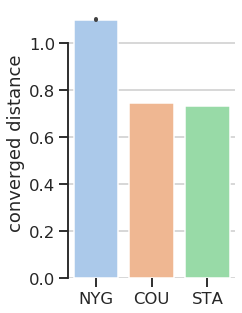

In [185]:
sns.set_context('talk')

f, ax = plt.subplots(figsize=(3,5))

sns.barplot(x="model", y="distance", data=eps, palette='pastel')

ax.yaxis.grid(True)
ax.set(xlabel="")
ax.set(ylabel="converged distance")
sns.despine(trim=True, bottom=True)

In [186]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/eps_compare.pdf')

## Plot simulation outputs

In [24]:
df_nyg, w_nyg = h_nyg_full.get_distribution()
df_cou_m, w_cou_m = h_cou_m.get_distribution()
df_cou_h, w_cou_h = h_cou_h.get_distribution()
df_cou_j, w_cou_j = h_cou_j.get_distribution()
df_sta, w_sta = h_sta.get_distribution()

In [25]:
from ionchannelABC.visualization import plot_sim_results

In [26]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_fast,
                                        sakakibara_inact_kin_slow,
                                        sakakibara_rec_fast,
                                        sakakibara_rec_slow)
from experiments.ina_schneider import (schneider_taum)

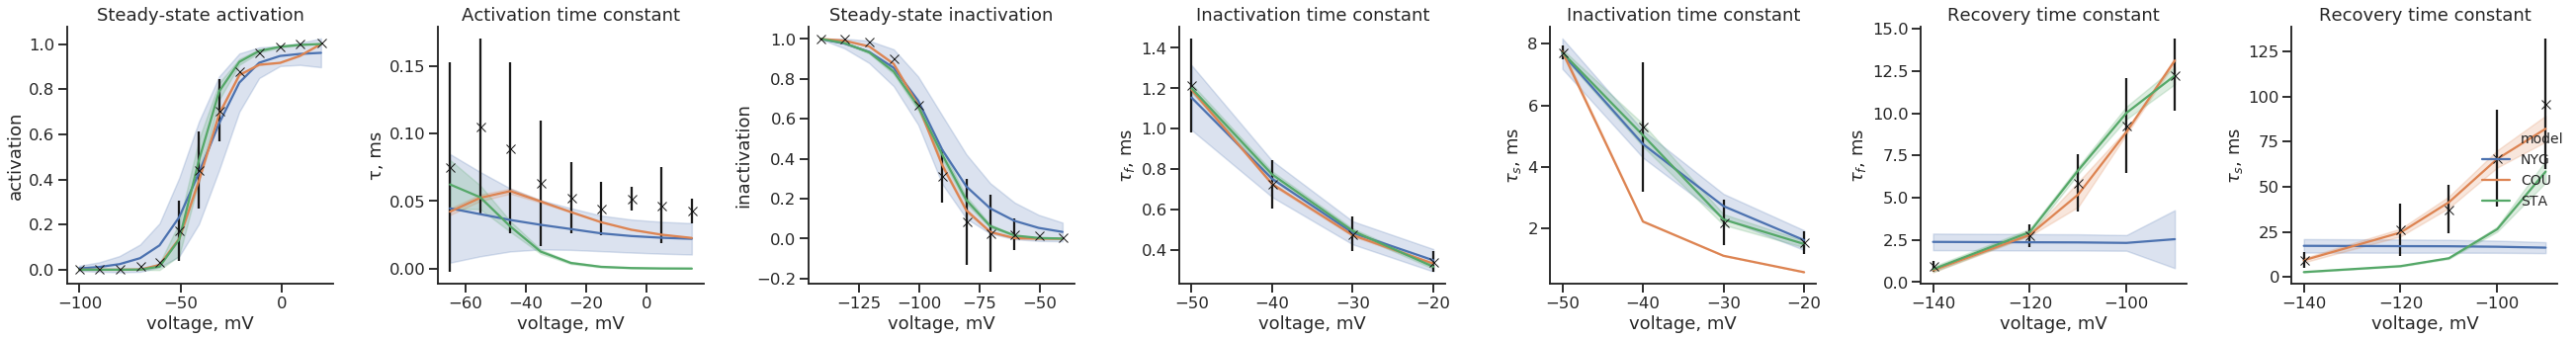

In [27]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(['models/nygren_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/courtemanche_ina.mmt',
                      'models/standardised_ina.mmt'],
                     sakakibara_act,
                     schneider_taum,
                     sakakibara_inact,
                     sakakibara_inact_kin_fast,
                     sakakibara_inact_kin_slow,
                     sakakibara_rec_fast,
                     sakakibara_rec_slow,
                     temp_match_model = 4,
                     masks=[None,
                            [0,1]+[None,]*5,
                            [None,]*2+[2,3,None,5,None],
                            [None,]*4+[4,None,6],
                            None],
                     df=[df_nyg,
                         df_cou_m,
                         df_cou_h,
                         df_cou_j,
                         df_sta], 
                     w=[w_nyg,
                        w_cou_m,
                        w_cou_h,
                        w_cou_j,
                        w_sta])

xlabels = ["voltage, mV"]*7
ylabels = ["activation", "τ, ms", "inactivation",
           "$τ_f$, ms", "$τ_s$, ms", "$τ_f$, ms", "$τ_s$, ms"]
titles = ["Steady-state activation", "Activation time constant", "Steady-state inactivation",
          "Inactivation time constant", "Inactivation time constant",
          "Recovery time constant", "Recovery time constant"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)
for ax, t in zip(g.axes.flatten(), titles):
    ax.set_title(t)

plt.tight_layout()

In [28]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/compare_out.pdf')

### Compare SS and tau values

In [76]:
df_nyg, w_nyg = h_nyg_full.get_distribution()
df_cou_m, w_cou_m = h_cou_m.get_distribution()
df_cou_h, w_cou_h = h_cou_h.get_distribution()
df_cou_j, w_cou_j = h_cou_j.get_distribution()
df_sta, w_sta = h_sta.get_distribution()

In [77]:
import myokit
nyg = 'models/nygren_ina.mmt'
cou ='models/courtemanche_ina.mmt'
std = 'models/standardised_ina.mmt'

In [78]:
v = np.arange(-140, 50, 0.5)

In [79]:
cou_vars = {'mi': 'ina.m_inf',
            'hi': 'ina.h_inf',
            'ji': 'ina.j_inf',
            'mt': 'ina.tau_m',
            'ht': 'ina.tau_h',
            'jt': 'ina.tau_j'}

In [80]:
nyg_vars = {'mi': 'ina.m_ss',
            'hi': 'ina.h_ss',
            'ji': 'ina.h_ss',
            'mt': 'ina.tau_m',
            'ht': 'ina.tau_h1',
            'jt': 'ina.tau_h2'}

In [81]:
from ionchannelABC.visualization import plot_variables

In [82]:
df_nyg_existing, w_nyg_existing = h_nyg_original.get_distribution()

In [83]:
nyg_pars_existing = df_nyg_existing.sample(n=100, weights=w_nyg_existing, replace=True)
nyg_pars_existing = nyg_pars_existing.set_index([pd.Index(range(100))])
nyg_pars_existing = nyg_pars_existing.to_dict(orient='records')

In [84]:
cou_pars_m = df_cou_m.sample(n=100, weights=w_cou_m, replace=True)
cou_pars_m = cou_pars_m.set_index([pd.Index(range(100))])
cou_pars_h = df_cou_h.sample(n=100, weights=w_cou_h, replace=True)
cou_pars_h = cou_pars_h.set_index([pd.Index(range(100))])
cou_pars_j = df_cou_j.sample(n=100, weights=w_cou_j, replace=True)
cou_pars_j = cou_pars_j.set_index([pd.Index(range(100))])
cou_pars = pd.concat([cou_pars_m,cou_pars_h,cou_pars_j],axis=1).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


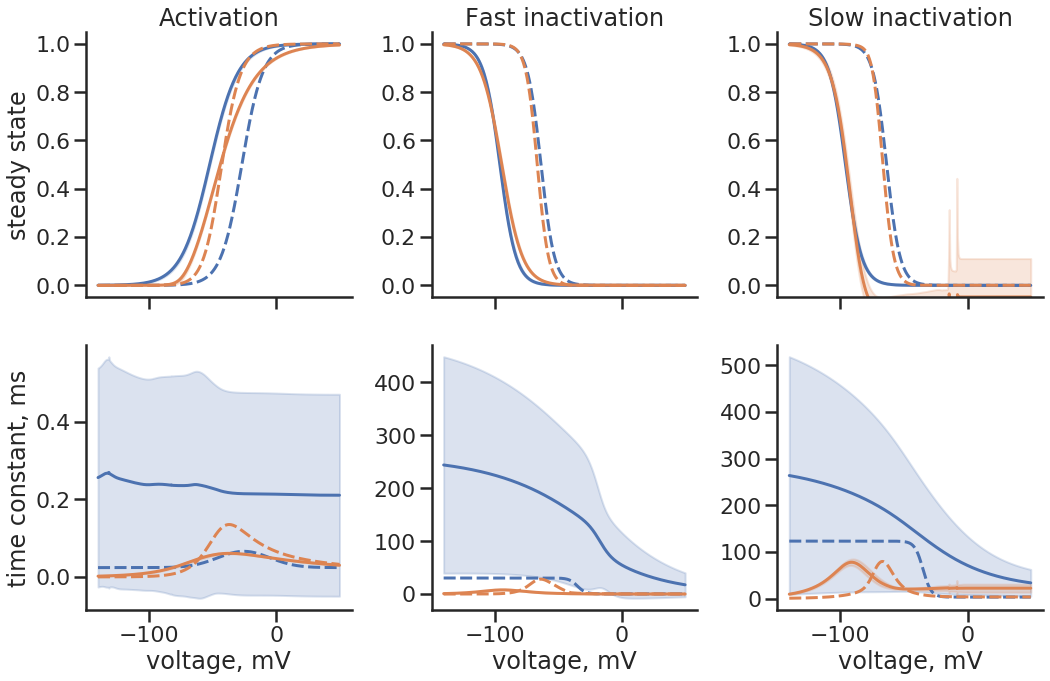

In [85]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_vars, cou_vars], 
                       [nyg, cou], 
                       [nyg_pars_existing, cou_pars],
                       original=True,
                       figshape=(3,2))

ax[0][0].set_ylabel('steady state')
for a in ax[0][1:]:
    a.set_ylabel('')
ax[0][0].set_title('Activation')
ax[0][1].set_title('Fast inactivation')
ax[0][2].set_title('Slow inactivation')

for a in ax[0][:]:
    a.set_ylim((-0.05, 1.05))

ax[1][0].set_ylabel('time constant, ms')
for a in ax[1][1:]:
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage, mV')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
    
plt.tight_layout()

In [86]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/ss_tau.pdf')

In [72]:
std_vars = {'mi': 'ina.m_ss',
            'hi': 'ina.h_ss',
            'ji': 'ina.h_ss',
            'mt': 'ina.tau_m',
            'ht': 'ina.tau_h1',
            'jt': 'ina.tau_h2'}

In [73]:
N = 100

nyg_pars = df_nyg.sample(n=N, weights=w_nyg, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(N))])
nyg_pars = nyg_pars.to_dict(orient='records')

cou_pars_m = df_cou_m.sample(n=N, weights=w_cou_m, replace=True)
cou_pars_m = cou_pars_m.set_index([pd.Index(range(N))])
cou_pars_h = df_cou_h.sample(n=N, weights=w_cou_h, replace=True)
cou_pars_h = cou_pars_h.set_index([pd.Index(range(N))])
cou_pars_j = df_cou_j.sample(n=N, weights=w_cou_j, replace=True)
cou_pars_j = cou_pars_j.set_index([pd.Index(range(N))])
cou_pars = pd.concat([cou_pars_m,cou_pars_h,cou_pars_j],axis=1).to_dict(orient='records')

std_pars = df_sta.sample(n=N, weights=w_sta, replace=True)
std_pars = std_pars.set_index([pd.Index(range(N))])
std_pars = std_pars.to_dict(orient='records')

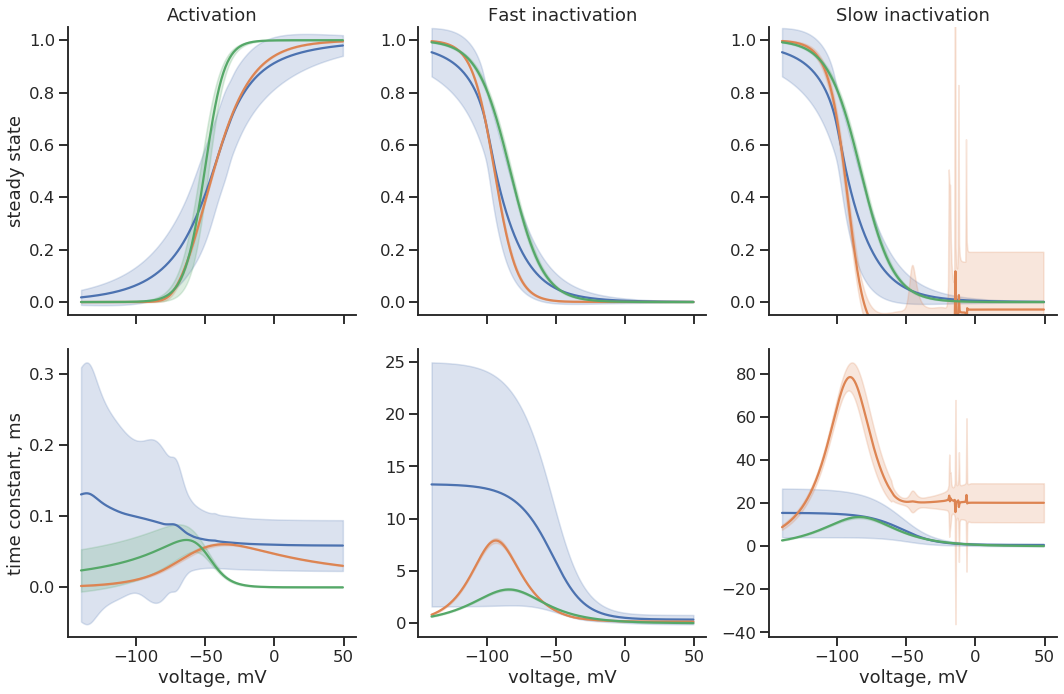

In [74]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(v, [nyg_vars, cou_vars, std_vars], 
                       [nyg, cou, std], 
                       [nyg_pars, cou_pars, std_pars],
                       #original=True,
                       figshape=(3,2))

ax[0][0].set_ylabel('steady state')
for a in ax[0][1:]:
    a.set_ylabel('')
ax[0][0].set_title('Activation')
ax[0][1].set_title('Fast inactivation')
ax[0][2].set_title('Slow inactivation')

for a in ax[0][:]:
    a.set_ylim((-0.05, 1.05))

ax[1][0].set_ylabel('time constant, ms')
for a in ax[1][1:]:
    a.set_ylabel('')
    
for a in ax[1][:]:
    a.set_xlabel('voltage, mV')
    
for a in ax.flatten():
    x0,x1 = a.get_xlim()
    y0,y1 = a.get_ylim()
    a.set_aspect(abs(x1-x0)/abs(y1-y0))
    
plt.tight_layout()

In [75]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/compare_gates.pdf')

### Compare final pulse after pulse train

In [49]:
import myokit

In [50]:
nsteps = 100
period = 1000
tstep = 100
vhold = -140
vstep = -30

pulsetrain = myokit.pacing.steptrain([vstep,]*nsteps,
                                     vhold,
                                     period-tstep,
                                     tstep)

In [87]:
# nygren_ina_full has had tau values adjusted for temperature to 310K
models = [myokit.load_model(modelfile) for modelfile in ['models/nygren_ina.mmt',
                                                         'models/courtemanche_ina.mmt',
                                                         'models/standardised_ina.mmt']]
for m in models:
    pace = m.get('membrane.V')
    if pace.binding() != 'pace':
        if pace.is_state():
            pace.demote()
        pace.set_rhs(0)
        pace.set_binding('pace')

In [52]:
sims = [myokit.Simulation(m, pulsetrain) for m in models]

In [53]:
df_nyg, w_nyg = h_nyg_full.get_distribution()
df_cou_m, w_cou_m = h_cou_m.get_distribution()
df_cou_h, w_cou_h = h_cou_h.get_distribution()
df_cou_j, w_cou_j = h_cou_j.get_distribution()
df_sta, w_sta = h_sta.get_distribution()

In [54]:
N = 100

nyg_pars = df_nyg.sample(n=N, weights=w_nyg, replace=True)
nyg_pars = nyg_pars.set_index([pd.Index(range(N))])
nyg_pars = nyg_pars.to_dict(orient='records')

cou_pars_m = df_cou_m.sample(n=N, weights=w_cou_m, replace=True)
cou_pars_m = cou_pars_m.set_index([pd.Index(range(N))])
cou_pars_h = df_cou_h.sample(n=N, weights=w_cou_h, replace=True)
cou_pars_h = cou_pars_h.set_index([pd.Index(range(N))])
cou_pars_j = df_cou_j.sample(n=N, weights=w_cou_j, replace=True)
cou_pars_j = cou_pars_j.set_index([pd.Index(range(N))])
cou_pars = pd.concat([cou_pars_m,cou_pars_h,cou_pars_j],axis=1).to_dict(orient='records')

std_pars = df_sta.sample(n=N, weights=w_sta, replace=True)
std_pars = std_pars.set_index([pd.Index(range(N))])
std_pars = std_pars.to_dict(orient='records')

par_samples = [nyg_pars, cou_pars, std_pars]

In [90]:
import time

all_samples = pd.DataFrame({})
for i, s in enumerate(sims):
    s.reset()
    # store original
    if models[i].name() != 'STA':
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ina.g','engine.time','membrane.V'],
                        log_interval=0.2)
        datalog = datalog.trim(9890, 9930, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ina.g']/max(datalog['ina.g']),
              'sample': 0,
              'model': models[i].name(),
              'type': 'original'}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)
    
    # re-calibrated
    for j, par_sample in enumerate(par_samples[i]):
        s.reset()
        for p, v in par_sample.items():
            name = p
            value = v
            if p.startswith("log"):
                name = p[4:]
                value = 10**v
            s.set_constant(name, value)
            
        # Log run time for comparisons
        t0 = time.time()
        datalog = s.run(pulsetrain.characteristic_time(),
                        log=['ina.g','engine.time','membrane.V'],
                        log_interval=0.2)
        t1 = time.time()
        dt = t1-t0
        
        datalog = datalog.trim(9890, 9930, adjust=True)
        df = {'time': datalog['engine.time'],
              'gate': datalog.npview()['ina.g']/max(datalog['ina.g']),
              'sample': j,
              'model': models[i].name(),
              'type': 'recalibrated',
              'runtime': dt}
        df = pd.DataFrame(df)
        all_samples = all_samples.append(df, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [114]:
modelname = 'STA'

In [115]:
np.mean(all_samples[(all_samples['model']==modelname) & (all_samples['type']=='recalibrated')].runtime)

0.4359070944786072

In [116]:
np.std(all_samples[(all_samples['model']==modelname) & (all_samples['type']=='recalibrated')].runtime)

0.04284659007344744

In [119]:
recalibrated_df = all_samples[all_samples['type']=='recalibrated']

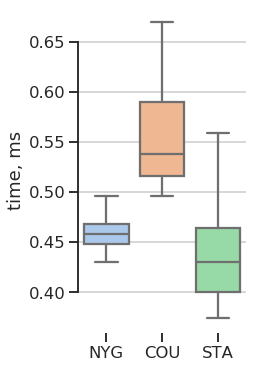

In [141]:
sns.set(style="ticks")
sns.set_context('talk')

# Initialize the figure
f, ax = plt.subplots(figsize=(3, 6))

# Plot the orbital period with horizontal boxes
sns.boxplot(x='model', y='runtime', data=recalibrated_df,
            palette="pastel", whis="range")

# Add in points to show each observation
#sns.swarmplot(x='model', y='runtime', data=recalibrated_df,
#              linewidth=0.5)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(ylabel="time, ms")
ax.set(xlabel="")
sns.despine(trim=True, bottom=True)

# statistical annotation
#x1, x2 = 0, 1   # columns
#y, h, col = recalibrated_df['runtime'].max() + 0.01, 0.01, 'k'
#plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#plt.text((x1+x2)*.5, y+h, "p < 0.001", ha='center', va='bottom', color=col)

In [142]:
f.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/runtime_compare.pdf')

In [127]:
ss.mannwhitneyu(recalibrated_df[recalibrated_df['model']=='NYG'].runtime, recalibrated_df[recalibrated_df['model']=='COU'].runtime)

MannwhitneyuResult(statistic=40000.0, pvalue=0.0)

In [151]:
ss.mannwhitneyu(recalibrated_df[recalibrated_df['model']=='NYG'].runtime, recalibrated_df[recalibrated_df['model']=='STA'].runtime)

MannwhitneyuResult(statistic=121800000.0, pvalue=0.0)

In [122]:
ss.mannwhitneyu(recalibrated_df[recalibrated_df['model']=='STA'].runtime, recalibrated_df[recalibrated_df['model']=='COU'].runtime)

MannwhitneyuResult(statistic=10440000.0, pvalue=0.0)

In [57]:
all_samples_detail = all_samples[(all_samples['time']>=9.8) & (all_samples['time'] < 14)]

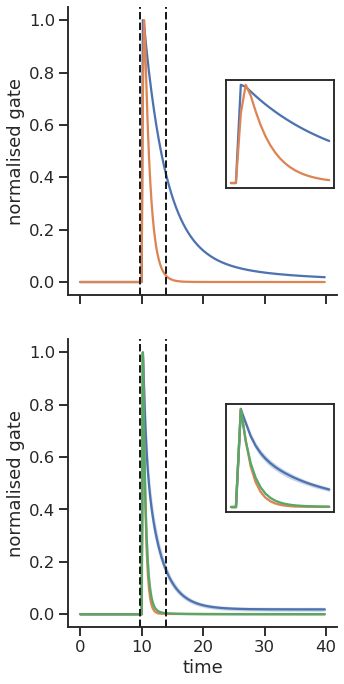

In [58]:
sns.set_context('talk')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = sns.relplot(x='time', y='gate', hue='model', row='type', 
                kind='line', data=all_samples,
                legend=False, height=5, aspect=1)

ax2 = plt.axes([.65, .7, .3, .15])
sns.lineplot(x='time',y='gate',hue='model',
             data=all_samples_detail[all_samples_detail['type']=='original'], ax=ax2,
             legend=False)
plt.setp(ax2, xticks=[], yticks=[])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax3 = plt.axes([.65, .25, .3, .15])
sns.lineplot(x='time',y='gate',hue='model',
             data=all_samples_detail[all_samples_detail['type']=='recalibrated'], ax=ax3,
             legend=False)
plt.setp(ax3, xticks=[], yticks=[])
ax3.set_xlabel('')
ax3.set_ylabel('')

for a in g.axes.flatten():
    a.set_ylabel('normalised gate')
    a.set_title('')
    a.axvline(x=9.8, linestyle='--', color='k', linewidth=2)
    a.axvline(x=14, linestyle='--', color='k', linewidth=2)

In [59]:
g.savefig('/storage/hhecm/cellrotor/chouston/abc-human-atrial-results/paper-figures/trace_compare_out.pdf')